In [2]:
import sys
import numpy as np
import scipy.stats as stats
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import pycircstat as pc


def print_progress (iteration, total, prefix = '', suffix = '', decimals = 2, barLength = 100):
        """
        Call in a loop to create terminal progress bar
        @params:
            iteration   - Required  : current iteration (Int)
            total       - Required  : total iterations (Int)
            prefix      - Optional  : prefix string (Str)
            suffix      - Optional  : suffix string (Str)
            decimals    - Optional  : number of decimals in percent complete (Int)
            barLength   - Optional  : character length of bar (Int)
        """
        filledLength    = int(round(barLength * iteration / float(total)))
        percents        = round(100.00 * (iteration / float(total)), decimals)
        bar             = '█' * filledLength + '-' * (barLength - filledLength)
        sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
        sys.stdout.flush()
        if iteration == total:
            sys.stdout.write('\n')
            sys.stdout.flush()

In [3]:

#First basic set up:
np.random.seed(8)
n_excitatory  = 500     # number of neurons
n_inhibitory  = 1

dt_ms         = .1    # integration step [ms]
dt_s = dt_ms/1000.0   # should really just use one dt, to avoid confusion
sim_length = 1     # total time of simulation [s]
n_timepoints  = int(sim_length//dt_s)
time   = np.linspace(0,sim_length,n_timepoints)

# current injection + noise (allowed to just be current :p) (in pA)
i1,i2 = int(200/dt_s),int(600/dt_s) # current injection timepoints
noise_input = 0*np.random.randn(n_excitatory,n_timepoints)
iclamp      = np.zeros((n_excitatory, n_timepoints))
iclamp[:,i1:i2]  = 0
iclamp[-1,i1:i2] = 0
i_ext_mat    = iclamp + noise_input

### Make distance matrix D ###

std_dev_d = 0.1
dist = stats.norm(.5,std_dev_d,)
x = np.linspace(0,1,n_excitatory)
y = dist.pdf(x)
y_shifted = np.roll(y, int(n_excitatory/2.0))
y_shifted[0] = 0 # so each neuron is not cooperating with itself

D = la.toeplitz(y_shifted)


#### External inputs - inhomogenous poisson process is really slow

# First need hump on the neurons...
std_dev_receptive = 0.05
loc_receptive     = 0.5
tuning_curve = stats.norm(loc_receptive,std_dev_receptive)
dist = np.linspace(0,1,n_excitatory) # down the track...
input_strenghts = tuning_curve.pdf(dist)
input_strenghts /= sum(input_strenghts)/10  # norm of guassian is always the same...
input_strenghts += 0.2

print(sum(input_strenghts), 'is integral of guassian')

# now sim inhom poission process
f = 40
gamma_func = lambda x: (np.sin(2*np.pi*f*x)+1)/2

lambda_ = 2000
spike_ext_mat = np.zeros((n_excitatory,n_timepoints))

print_progress(0,len(input_strenghts), prefix = '% :', suffix = 'Complete', barLength = 50)
for i,input_strength in enumerate(input_strenghts):
    if i%10 == 0:
        print_progress(i,len(input_strenghts), prefix = '% :', suffix = 'Complete', barLength = 50)
    row = np.zeros(time.shape)

    for j,t in enumerate(time):
        row[j] =  np.random.poisson((lambda_*input_strength)*gamma_func(t)*dt_s)# dt_s to get the corre

    spike_ext_mat[i,:] = row


'''

cell_n, spike_times = [],[]
t_index = time
for row_i in range(spike_ext_mat.shape[0]):
    x = n_excitatory-row_i # otherwise scatter will be flipped vs the tuning
    spikes_row_for_indexing = spike_ext_mat[row_i, :].copy()

    # loop through removing 1 from the count each time
    while sum(spikes_row_for_indexing) != 0:
        s_times = time[np.where(spikes_row_for_indexing>=1)]
        cell_x  = np.ones(s_times.shape)*x
        spikes_row_for_indexing[np.where(spikes_row_for_indexing>=1)] -= 1

        cell_n.append(cell_x)
        spike_times.append(s_times)

cell_n = np.hstack(np.array(cell_n))
spike_times = np.hstack(np.array(spike_times))

'''


110.0 is integral of guassian
% : |█████████████████████████████████████████████████-| 98.0% Complete

'\n\ncell_n, spike_times = [],[]\nt_index = time\nfor row_i in range(spike_ext_mat.shape[0]):\n    x = n_excitatory-row_i # otherwise scatter will be flipped vs the tuning\n    spikes_row_for_indexing = spike_ext_mat[row_i, :].copy()\n\n    # loop through removing 1 from the count each time\n    while sum(spikes_row_for_indexing) != 0:\n        s_times = time[np.where(spikes_row_for_indexing>=1)]\n        cell_x  = np.ones(s_times.shape)*x\n        spikes_row_for_indexing[np.where(spikes_row_for_indexing>=1)] -= 1\n\n        cell_n.append(cell_x)\n        spike_times.append(s_times)\n\ncell_n = np.hstack(np.array(cell_n))\nspike_times = np.hstack(np.array(spike_times))\n\n'

In [4]:
# convolve spikes with synaptic kernels
# this is in seconds, whereas sim code is in ms. Not good. 

ge_ext_mat = np.zeros((n_excitatory,n_timepoints))
gi_ext_mat = np.zeros((n_inhibitory,n_timepoints))

# pyramidal external input
tau1 = 3.5 /1000# this is in ms
tau2 = .7 /1000
g0 = np.exp(-time/tau1) - np.exp(-time/tau2)
g0 = g0/np.sum(g0)/dt_ms # don't get this step...

# pv external input
tau1_pv = 1.1/1000
tau2_pv = .35/1000
g1 = np.exp(-time/tau1_pv) - np.exp(-time/tau2_pv)
g1 = g1/np.sum(g1)/dt_ms

for i in range(spike_ext_mat.shape[0]-1):
    #pyg_ext_row = np.convolve(s_ext_mat[i,:],g0,mode='full')[0:n_timepoints]
    pyg_ext_row = np.real(np.fft.ifft(np.fft.fft(spike_ext_mat[i,:])*np.fft.fft(g0))) # FFT convolution
    ge_ext_mat[i,:] = pyg_ext_row

pvg_ext_row = np.real(np.fft.ifft(np.fft.fft(spike_ext_mat[0,:])*np.fft.fft(g1)))
gi_ext_mat[0,:] = pvg_ext_row


# PV cell
class PV:
    'To store parameters for PV cell as class variables'
    cm     = 90    # total membrane capaciatance
    v_r    = -60.6
    v_t    = -43.1
    v_peak = 2.5
    a      = 0.1
    b      = -0.1
    c      = -70#67
    d      = 0.1
    k_low  = 1.7
    k_high = 14

    # syanptic parameters
    tau1_gaba  = 6.5#10
    tau2_gaba   = 0.6#1

    e_glu   = 0
    e_gaba  = -70 

class Py:
    'To store parameters for PV cell as class variables'
    cm     = 100
    v_r    = -70.8 # their intial is 61.8
    v_t    = -57.0
    v_peak = 22.6
    a      = 0.001#2
    b      = 3
    c      = -62.8
    d      = 10
    k_low  = 0.5
    k_high = 3.3
    i_shift = 0

    # syanptic parameters
    tau1_ampa   = 3 # 1st 10
    tau2_ampa   = 0.7 # # list 1 # tau 2 is the rise

    # calling nmda even though not!
    tau1_NMDA   = 80
    tau2_NMDA   = 2


    e_glu   = 0
    e_gaba  = -70


In [ ]:
# params dict
# n_excitatory, n_inhibitory, 

In [30]:
def simulation(EIL_gain=3, EINL_gain=0.2):
    # run simulation
    # future - global and individaul gains
    Ext_gain  = 5.5 #5.5
    #EIL_gain  = 3#9.5#3#2.5   # E to I linear gain (multiplies LV)
    #EINL_gain = 0.25#.5#2#0.5        # E to I non-linear gain
    IEL_gain  = 1        # I to E linear gain (multiplies inhib_vec_gains (bad name) individualinhibitory gains)

    #gains
    IE_vec_gains = 40*np.ones((n_excitatory))                 # inhibitory gains from pv conductance onto other cells
    II_vec_gains = 30*5 /IEL_gain                         # set to specifiy the auto inhibition - de mess this!
    EI_linear_vec_gains = 4*100/n_excitatory*np.ones((n_excitatory)) # gains for the excitatory onto the inhib
    
    traces = np.zeros((3, n_timepoints))

    Ve_mat  = np.zeros((n_excitatory,n_timepoints))    # to hold v_membrane traces
    Ve_mat[:,0]  = -70+2*np.random.randn(n_excitatory) # should really be set from class params
    Vi_mat  = np.zeros((n_inhibitory,n_timepoints))    # to hold v_membrane traces
    Vi_mat[:,0]  = -60+0*np.random.randn(n_inhibitory) # should really be set from class params

    Ue_mat  = np.zeros((n_excitatory,n_timepoints))    # hold the recurrent U values (in izhikevich) #was 40
    Ue_mat[:,0]  = 7+10*np.random.randn(n_excitatory)  # this is kind of where the settle
    Ui_mat  = np.zeros((n_inhibitory,n_timepoints))    # hold the recurrent U values (in izhikevich) #was 40
    Ui_mat[:,0]  = 0

    # excitatory bi-exponential syanpses
    G1_mat  = np.zeros((n_excitatory,n_timepoints))   # G holds the "standard ampa-like" conductances elicited onto connected
    G2_mat  = np.zeros((n_excitatory,n_timepoints))   # neurons by this neuron. Last row is for inhib.
    G1NL_mat  = np.zeros((n_excitatory,n_timepoints)) # G NL holds the conductances dependent on coaactivation of
    G2NL_mat  = np.zeros((n_excitatory,n_timepoints)) # neighbouring synpases

    # inhibitory bi-exponential syanpses
    Gi1_mat  = np.zeros((n_inhibitory,n_timepoints))   # G holds the "standard ampa-like" conductances elicited onto connected
    Gi2_mat  = np.zeros((n_inhibitory,n_timepoints))   # neurons by this neuron. Last row is for inhib.


    print_progress(0,n_timepoints, prefix = 'Simulation:', suffix = 'Complete', barLength = 30)
    for i in range(n_timepoints-1): 
        if i%100 == 0:
            print_progress(i,n_timepoints, prefix = 'Simulation:', suffix = 'Complete', barLength = 30)
        Ve      = Ve_mat[:,i] 
        ue      = Ue_mat[:,i]
        Vi      = Vi_mat[:,i] 
        ui      = Ui_mat[:,i]
        i_ext   = i_ext_mat[:,i]      # is this being used?
        ge_ext  = Ext_gain*ge_ext_mat[:,i]
        gi_ext  = Ext_gain*gi_ext_mat[:,i]

        G1      = G1_mat[:,i] 
        G2      = G2_mat[:,i]
        Gi1     = Gi1_mat[:,i] 
        Gi2     = Gi2_mat[:,i]

        G       = EIL_gain*(G1-G2)     # change with global gains
        Gi      = IEL_gain*(Gi1-Gi2)
        G1NL    = G1NL_mat[:,i]
        G2NL    = G2NL_mat[:,i]
        GNL     = EINL_gain*(G1NL-G2NL) 

        # check which k  to use 
        ke_vec  = Py.k_high + (Py.k_low - Py.k_high)*(Ve <=Py.v_t)
        ki_vec  = PV.k_high + (PV.k_low - PV.k_high)*(Vi <=PV.v_t)

        # Euler integration scheme
        # Excitatory neurons
        # start by calculating current from conductances
        i_syn = (IE_vec_gains*Gi*(Py.e_gaba - Ve)    # combine external glu and gaba here
                + ge_ext*(Py.e_glu  - Ve)   # excitatory external
                )                         
        i_app = i_syn                    # i_ext +  isyn add in applied current if you are using it 
        dVe   = ((ke_vec*(Ve-Py.v_r)*(Ve-Py.v_t) - ue + i_app)/Py.cm)*dt_ms 
        due   = Py.a*(Py.b*(Ve-Py.v_r) - ue)*dt_ms

        # adjust values of dV or du if neuron fired
        dVe[Ve>Py.v_peak] = -Ve[Ve>Py.v_peak] + Py.c
        due[Ve>Py.v_peak] = due[Ve>Py.v_peak] + Py.d

        # Inhibitory neuron
        nl_i       = np.sqrt(GNL.T.dot(D.dot(GNL)))*(PV.e_glu - Vi) # calculate the nl "nmda conductance"
        l_i        = EI_linear_vec_gains.T.dot(G) *(PV.e_glu - Vi)                   # excitatory conductance  
        pv_gaba_i  = II_vec_gains*Gi*(PV.e_gaba - Vi)       # 

        i_syn_pv   = ( pv_gaba_i             # inhibitory auto connection... 
                     + nl_i                  # non-linear - only large when coactivation of nearby synapses
                     + l_i                   # linear 
                     + ((.0*gi_ext)*(PV.e_glu - Vi[-1])) )    # external... then ∑g's and * driving force. 
 
        i_app_pv = i_syn_pv                  # _ext[-1] +  used to be here    
        dVi = ((ki_vec*(Vi-PV.v_r)*(Vi-PV.v_t) - ui + i_app_pv)/PV.cm)*dt_ms
        dui = PV.a*(PV.b*(Vi-PV.v_r) - ui)*dt_ms

        # adjust values if neuron fired
        dVi[Vi>PV.v_peak] = -Vi[Vi>PV.v_peak] + PV.c
        dui[Vi>PV.v_peak] = dui[Vi>PV.v_peak] + PV.d


        # Py synapses
        # excitatory linear
        dG1 = 1/Py.tau1_ampa*(-G1)*dt_ms + (Ve>=Py.v_peak)     # bi-exponential decay, add 1 if spike.
        dG2 = 1/Py.tau2_ampa*(-G2)*dt_ms + (Ve>=Py.v_peak) 

        # excitatory non-linear
        dG1NL = 1/Py.tau1_NMDA*(-G1NL)*dt_ms + (Ve>=Py.v_peak) # bi-exponential decay 
        dG2NL = 1/Py.tau2_NMDA*(-G2NL)*dt_ms + (Ve>=Py.v_peak)

        # PV synapses
        # inhibitory gaba
        dGi1 = 1/PV.tau1_gaba*(-Gi1[-1])*dt_ms + (Vi>=PV.v_peak)
        dGi2 = 1/PV.tau2_gaba*(-Gi2[-1])*dt_ms + (Vi>=PV.v_peak)

        dVe[dVe>50] = 50;          # stop voltage changing too quickly (for improved numerical stability when neurons spike)
        dVi[dVi>50] = 50; 


        Vi_mat[:,i+1]  = Vi + dVi     # update everything
        Ui_mat[:,i+1]  = ui + dui
        Ve_mat[:,i+1]  = Ve + dVe     
        Ue_mat[:,i+1]  = 0#ue + due
        G1_mat[:,i+1] = G1 + dG1
        G2_mat[:,i+1] = G2 + dG2
        G1NL_mat[:,i+1] = G1NL + dG1NL
        G2NL_mat[:,i+1] = G2NL + dG2NL
        Gi1_mat[:,i+1]  = Gi1 +dGi1
        Gi2_mat[:,i+1]  = Gi2 +dGi2

        #print(nl_g)
        #print(l_g)
        #print(pv_gaba_g)
        traces[0,i+1] = nl_i
        traces[1,i+1] = l_i
        traces[2,i+1] = pv_gaba_i

    G_mat   = G1_mat - G2_mat
    GNL_mat = G1NL_mat - G2NL_mat
    
    spiking_neurons = []
    for i,n in enumerate(np.sum(Ve_mat>=Py.v_peak,axis=1)):
        for j in range(n):
            spiking_neurons.append((i/n_excitatory)*360)
    print('Linear: ', EIL_gain,'NL:', EINL_gain, 'Vec length: ', pc.vector_strength(np.radians(spiking_neurons)) )
    return (Ve_mat, Vi_mat, traces)

In [20]:
l_nl_gains = [(0,0), (3,0),(6,0),(9,0),(12,0), (16,0), (3,0.2),(6,0.2),(9,0.2),(12,0.2), (16,0.2)]
for gaintuple in l_nl_gains:
    simulation(gaintuple[0],gaintuple[1])

Simulation: |██████████████████████████████| 99.01% CompleteLinear:  0 NL: 0 Vec length:  0.0832546723085
Simulation: |██████████████████████████████| 99.01% CompleteLinear:  3 NL: 0 Vec length:  0.326131779443
Simulation: |██████████████████████████████| 99.01% CompleteLinear:  6 NL: 0 Vec length:  0.369367131571
Simulation: |██████████████████████████████| 99.01% CompleteLinear:  9 NL: 0 Vec length:  0.419991442663
Simulation: |██████████████████████████████| 99.01% CompleteLinear:  12 NL: 0 Vec length:  0.446168833903
Simulation: |██████████████████████████████| 99.01% CompleteLinear:  16 NL: 0 Vec length:  0.467325657399
Simulation: |██████████████████████████████| 99.01% CompleteLinear:  3 NL: 0.2 Vec length:  0.500527796935
Simulation: |██████████████████████████████| 99.01% CompleteLinear:  6 NL: 0.2 Vec length:  0.53938281117
Simulation: |██████████████████████████████| 99.01% CompleteLinear:  9 NL: 0.2 Vec length:  0.527691230564
Simulation: |██████████████████████████████| 99

In [54]:
Ve_mat, Vi_mat, traces = simulation(7,0.5)

Simulation: |██████████████████████████████| 99.01% CompleteLinear:  7 NL: 0.5 Vec length:  0.584936948042


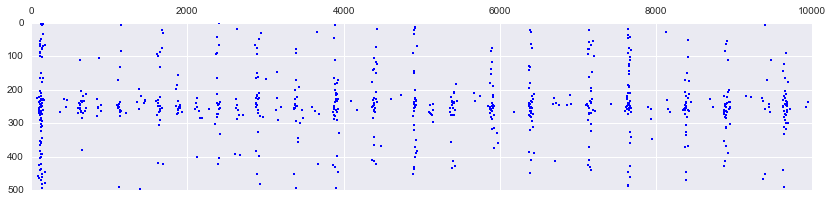

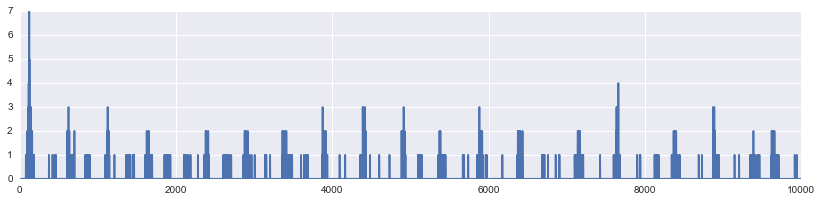

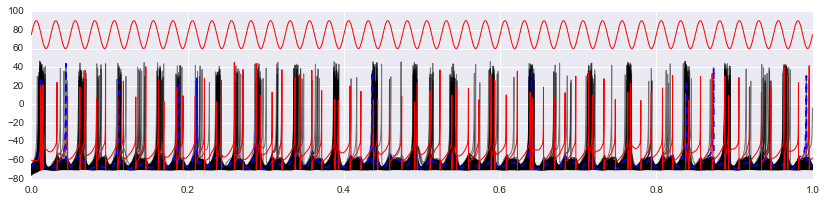

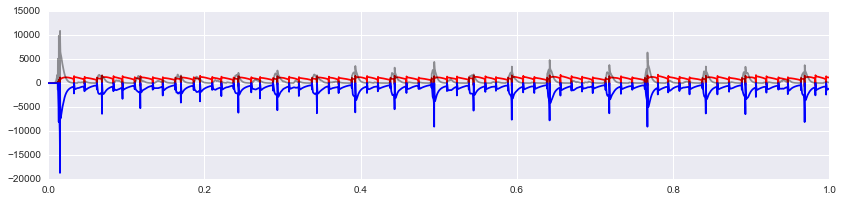

In [52]:
plt.figure(figsize=(14,3))
#plt.suptitle(' 2.5 L gain, 0 NL gain')
plt.spy(Ve_mat>=Py.v_peak,aspect='auto',markersize=2);
#plt.xlim(2000,5000)
#plt.figure(figsize=(14,3))

plt.figure(figsize=(14,3))
#plt.suptitle(' 2.5 L gain, 0 NL gain')
plt.plot(np.sum(Ve_mat>=Py.v_peak,axis=0))

plt.figure(figsize=(14,3))
plt.plot(time,(gamma_func(time)*30)+60, 'r', linewidth = 1)
plt.plot(time, Ve_mat[:-1,:].T, 'k', linewidth = 1, alpha = 0.5);
#plt.plot(time, V_mat[-1,:].T, 'r');
plt.plot(time, Ve_mat[n_excitatory//2,:].T, 'b--');
plt.plot(time, Vi_mat[:,:].T, 'r-', linewidth= 1);

#plt.figure(figsize=(14,3))
#plt.plot(time,Ue_mat.T, linewidth = 1);
#plt.plot(time, Ue_mat[n_excitatory//2,:].T, 'b--');

#plt.figure(figsize=(14,3))
#¢plt.plot(time,G_mat[:-1,:].T*5,'k')   # this is the excitatory synapses onto the pv cell
#plt.plot(time,GNL_mat[:-1,:].T,'r')   # this is the NL excitatory synapses onto the pv cell
#plt.plot(time,-G_mat[-1,:].T,'b')     # inhib conductance onto pyramdial cells

plt.figure(figsize=(14,3))
plt.plot(time,traces[0], 'r', label = 'nmda')
plt.plot(time,traces[1], 'k', label = 'ampa', alpha = 0.4)
#plt.plot(time,traces[1]+traces[0], 'k--', label = 'ampa+nmda', alpha = 1)
plt.plot(time,traces[2], 'b', label = 'gaba',)
#plt.ylim(-800,1000)

In [55]:
param_options = {"linear" : np.arange(0,40,3),
                 'nlinear': np.arange(0,1,0.1)
                 }

In [59]:
from collections import Mapping
from itertools import product
def get_possible_models(param_options):
    '''
    Returns a list containing dictionaries of possible models
    based on the input param_options dictionary
    '''
    if isinstance(param_options, Mapping):
        # wrap dictionary in a singleton list to support either dict
        # or list of dicts
        param_grid = [param_options]

    possible_models = list()
    for p in param_grid:
        # Always sort the keys of a dictionary, for reproducibility
        items = sorted(p.items())
        if not items:
            print ('wagwan')
        else:
            keys, values = zip(*items)
            for v in product(*values):
                params = dict(zip(keys, v))
                possible_models.append(params)
    return possible_models
possible_models = get_possible_models(param_options)
len(possible_models)

140

In [60]:
possible_models

[{'linear': 0, 'nlinear': 0.0},
 {'linear': 0, 'nlinear': 0.10000000000000001},
 {'linear': 0, 'nlinear': 0.20000000000000001},
 {'linear': 0, 'nlinear': 0.30000000000000004},
 {'linear': 0, 'nlinear': 0.40000000000000002},
 {'linear': 0, 'nlinear': 0.5},
 {'linear': 0, 'nlinear': 0.60000000000000009},
 {'linear': 0, 'nlinear': 0.70000000000000007},
 {'linear': 0, 'nlinear': 0.80000000000000004},
 {'linear': 0, 'nlinear': 0.90000000000000002},
 {'linear': 3, 'nlinear': 0.0},
 {'linear': 3, 'nlinear': 0.10000000000000001},
 {'linear': 3, 'nlinear': 0.20000000000000001},
 {'linear': 3, 'nlinear': 0.30000000000000004},
 {'linear': 3, 'nlinear': 0.40000000000000002},
 {'linear': 3, 'nlinear': 0.5},
 {'linear': 3, 'nlinear': 0.60000000000000009},
 {'linear': 3, 'nlinear': 0.70000000000000007},
 {'linear': 3, 'nlinear': 0.80000000000000004},
 {'linear': 3, 'nlinear': 0.90000000000000002},
 {'linear': 6, 'nlinear': 0.0},
 {'linear': 6, 'nlinear': 0.10000000000000001},
 {'linear': 6, 'nlinear'